# QC and data normalization

## *10x Adult Brain Dataset*

In [1]:
library(Signac)
library(Seurat)
library(EnsDb.Hsapiens.v86)
library(BSgenome.Hsapiens.UCSC.hg38)
library(ggplot2)
library(pheatmap)
library(viridis)
library(RColorBrewer)
set.seed(3452)

setwd("/lustre/groups/ies/projects/hamperl_lab/elizabeth.marquezgom/scMultiomicsCourse")

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t


Loading required package: ensembldb

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following object is masked from ‘package:SeuratObject’:

    intersect


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, saveRDS, setdiff,
    table, tapply, union, unique, unsplit, which.max, which.min


Loading required package: GenomicRanges

Loading required package: stats4

Loading

### Import genome annnotations

In [ ]:
## Get gene annotations for hg38 genome
annotation <- GetGRangesFromEnsDb(ensdb = EnsDb.Hsapiens.v86)
seqlevels(annotation) <- paste0('chr', seqlevels(annotation))
genome(annotation) <- 'hg38'

Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warn

### Create RNA and ATAC objects

In [3]:
## Load objects
counts_raw <- Read10X_h5(filename = "data/human_brain_3k_raw_feature_bc_matrix.h5")
counts_filtered <- Read10X_h5(filename = "data/human_brain_3k_filtered_feature_bc_matrix.h5")

## Load metadata
metadata <- read.csv(
  file = "data/human_brain_3k_per_barcode_metrics.csv",
  header = TRUE,
  row.names = 1
)

Genome matrix has multiple modalities, returning a list of matrices for this genome

Genome matrix has multiple modalities, returning a list of matrices for this genome



In [4]:
## Import list of cell barcodes to be used for the analysis
cell_subset <- readRDS("data/lessonCells_byCluster.RDS")

In [5]:
## Create a Seurat object containing the RNA adata
multi_object <- CreateSeuratObject(
  counts = counts_raw$`Gene Expression`[,cell_subset], 
  assay = "RNA",
  meta.data = metadata, 
  project = "Brain",  
  min.features = 1,
  min.cells = 1
)

In [6]:
## Create ATAC assay and add it to the object
multi_object[["ATAC"]] <- CreateChromatinAssay(
  counts = counts_raw$Peaks[,Cells(multi_object[['RNA']])], # subset the matrix to keep only cells that are in the RNA object
  sep = c(":", "-"),
  fragments = "data/human_brain_3k_atac_fragments.tsv.gz",
  annotation = annotation,
  genome='hg38', 
  validate.fragments = T,
  min.features = 1,
  min.cells = 1
)

Computing hash



In [7]:
multi_object <- subset(multi_object, cells=Cells(multi_object[['ATAC']]))
multi_object

An object of class Seurat 
163885 features across 2736 samples within 2 assays 
Active assay: RNA (29856 features, 0 variable features)
 1 layer present: counts
 1 other assay present: ATAC

In [8]:
## Clean up memory
rm(counts_filtered)
rm(counts_raw)
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,15297499,817.0,22283878,1190.1,22283878,1190.1
Vcells,95429129,728.1,271163883,2068.9,338954762,2586.1


## Quality control

### RNA-seq QC metrics

In [9]:
## Compute % mitochondrial reads
DefaultAssay(multi_object) <- "RNA"
# The [[ operator can add columns to object metadata
multi_object[["percent.mt"]] <- PercentageFeatureSet(multi_object, pattern = "^MT-")
multi_object[["percent.mt"]]


,percent.mt
,<dbl>
AAACCAACATAGACCC-1,0.00000000
AAACCGAAGATGCCTG-1,0.10478748
AAACCGAAGTTAGCTA-1,0.12864494
AAACCGCGTCTTACTA-1,0.63106796
AAACCGGCAATCCCTT-1,0.36949828
AAACCGGCAGCAACAG-1,1.97628458
AAACGCGCATTGGGAG-1,0.24373259
AAACGGATCATGAAGG-1,0.18288222
AAAGCACCAAGTAAGC-1,1.47058824


**Distribution pre-filtering**

Warning message:
"Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead."


Warning message:
"The `slot` argument of `FetchData()` is deprecated as of SeuratObject 5.0.0.
ℹ Please use the `layer` argument instead.
ℹ The deprecated feature was likely used in the Seurat package.
  Please report the issue at <https://github.com/satijalab/seurat/issues>."
Warning message:
"`PackageCheck()` was deprecated in SeuratObject 5.0.0.
ℹ Please use `rlang::check_installed()` instead.
ℹ The deprecated feature was likely used in the Seurat package.
  Please report the issue at <https://github.com/satijalab/seurat/issues>."


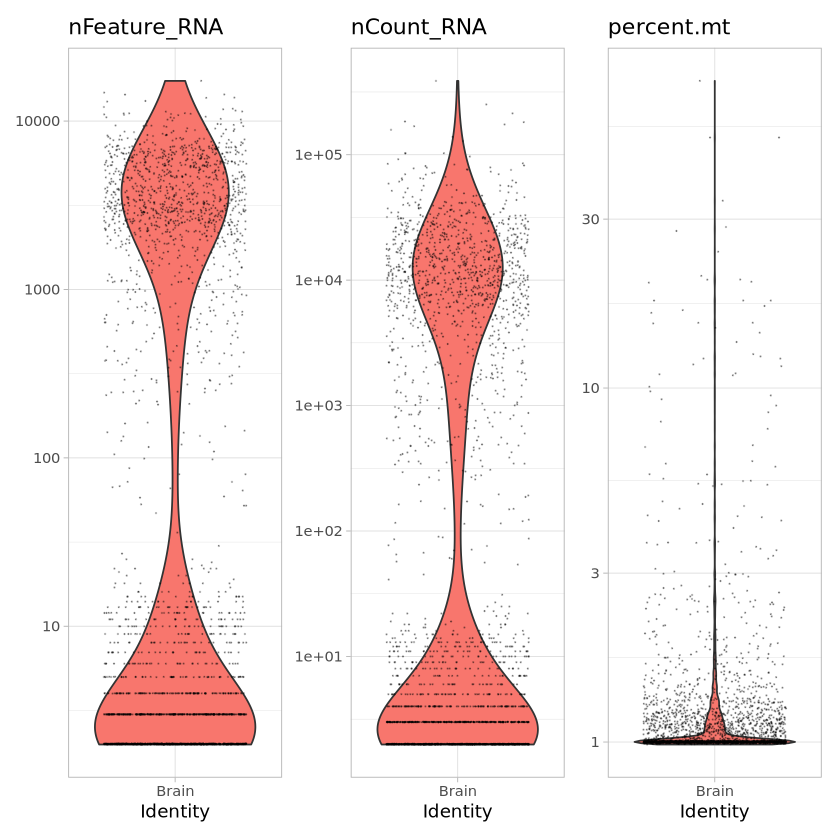

In [10]:
## Computing QC plots
# Distributions are bimodal indicating two groups of cells, top is good quality cells and bottom is low quality cells
VlnPlot(
  object = multi_object,
  features = c("nFeature_RNA", "nCount_RNA", "percent.mt"),  
  pt.size = 0.01, alpha = 0.3, ncol=3, log = TRUE
) & theme_light() & NoLegend() 

Warning message in scale_y_log10():
"log-10 transformation introduced infinite values."


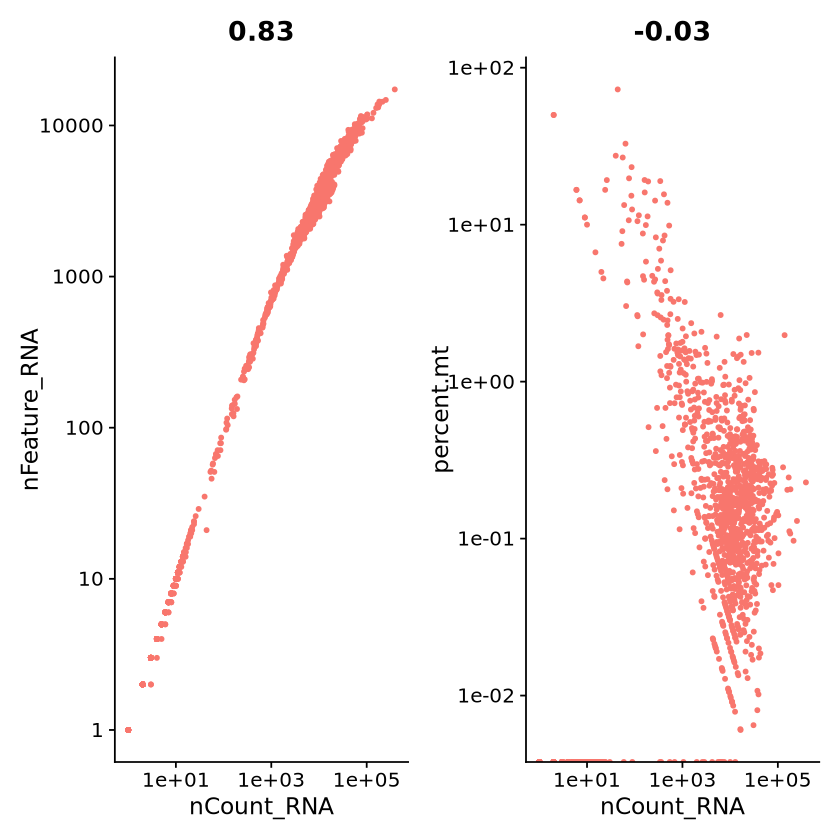

In [11]:
## Correlations between QC metrics
plot1 <- FeatureScatter(multi_object, feature1 = "nCount_RNA", feature2 = "nFeature_RNA", log=TRUE) + NoLegend()
plot2 <- FeatureScatter(multi_object, feature1 = "nCount_RNA", feature2 = "percent.mt", log=TRUE) + NoLegend() ## It might be correlated but the correlation coefficient is very low because of the 0's
plot1 + plot2 # the plot title is the correlation between the 2 metrics

*"log-10 transformation introduced infinite values." --> Because we have 0's in the data.*

### ATAC-seq QC metrics

In [12]:
DefaultAssay(multi_object) <- "ATAC"

## Compute nucleosome signal score (per cell) - Periodic pattern of nucleosome positioning
multi_object <- NucleosomeSignal(object = multi_object)

## Compute TSS enrichment score (per cell) - Expected enrichment of reads at transcription start sites compared to regions out of the TSS (serves as sanity check)
multi_object <- TSSEnrichment(object = multi_object, fast = FALSE) # the long version doesn't work

## Compute the fraction of reads in peaks (per cell)
multi_object$pct_reads_in_peaks <- multi_object$atac_peak_region_fragments / multi_object$atac_fragments * 100 

## Compute the fraction of reads overlapping ENCODE blacklist regions (per cell)
multi_object$blacklist_fraction <- FractionCountsInRegion(
  object = multi_object,
  assay = 'ATAC',
  regions = blacklist_hg38 
)


Extracting TSS positions

Finding + strand cut sites

Finding - strand cut sites

Computing mean insertion frequency in flanking regions

Normalizing TSS score



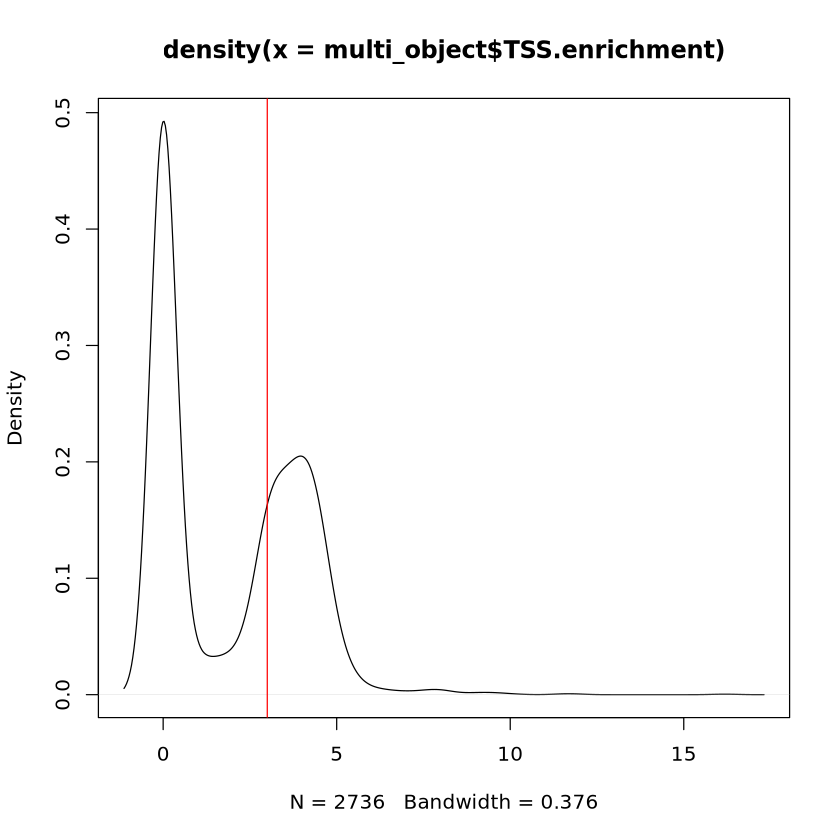

In [13]:
## TSS enrichment
# Group cells based on the TSS enrichment score and plot the accessibility signal over all TSS sites. 
# If the data is good, there should be a very distinct peak corresponding to the TSS.

## Bimodal is good, ideally line should separate the two groups in the valley
par(bg = "white")  # to set white packground for the plot
plot(density(multi_object$TSS.enrichment))
abline(v=3, col="red")

In [14]:
summary(multi_object$TSS.enrichment)

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
 0.000000  0.001227  1.598402  1.941201  3.773639 16.183816 

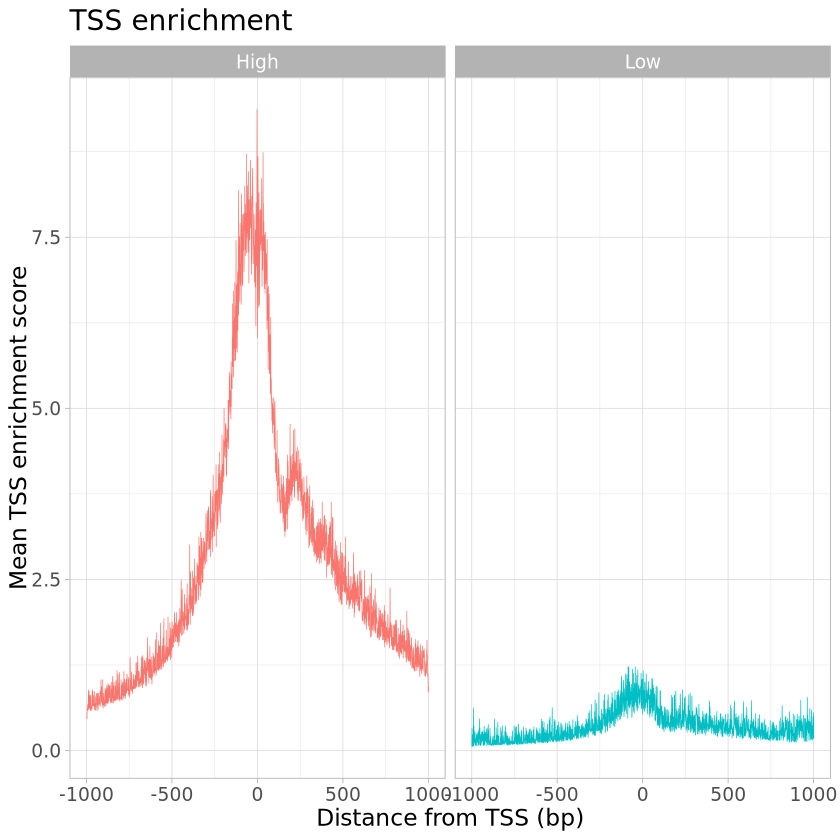

In [ ]:
## It hows a small shoulder dowstream the TSS peak. 3 is standard threshold.
# The plot here is the curve based on the computed score threshold. The enrichment score is a quantification of how strong the signal is at the TSS.
multi_object$high.tss <- ifelse(multi_object$TSS.enrichment > 3, 'High', 'Low')
TSSPlot(multi_object, group.by = 'high.tss') + 
  theme_light() + theme(text=element_text(size=14)) + NoLegend() 

In [17]:
table(multi_object$high.tss)


High  Low 
1101 1635 

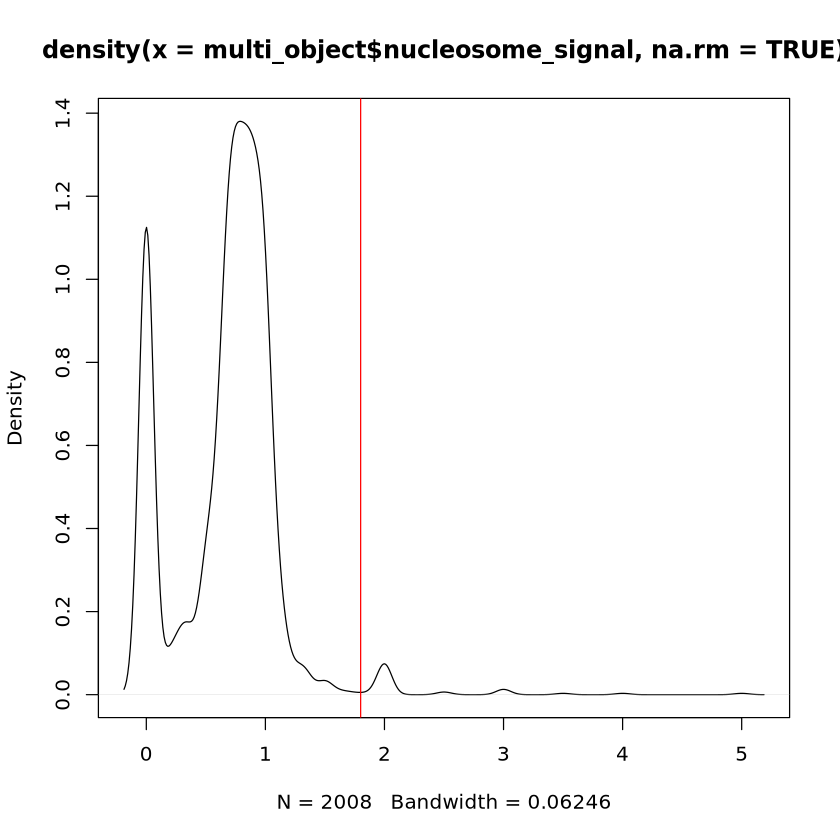

In [18]:
## Nucleosome signal
# The nucleosome signal is a measure of the periodicity of the nucleosome positioning.
# The plot shows the distribution of the nucleosome signal across all cells.
# Cells outliers for the mononucleosomal / nucleosome-free ratio have different nucleosomal binding patterns. The remaining cells exhibit a pattern that is typical for a successful ATAC-seq experiment.
# If restriction enzyme is cutting to much, peak at 2 would be higher 
par(bg = "white")  # to set white packground for the plot
plot(density(multi_object$nucleosome_signal, na.rm=TRUE))
abline(v=1.8, col="red")

Warning message:
"Removed 880 rows containing non-finite outside the scale range (`stat_bin()`)."
Warning message:
"Removed 4 rows containing missing values or values outside the scale range
(`geom_bar()`)."


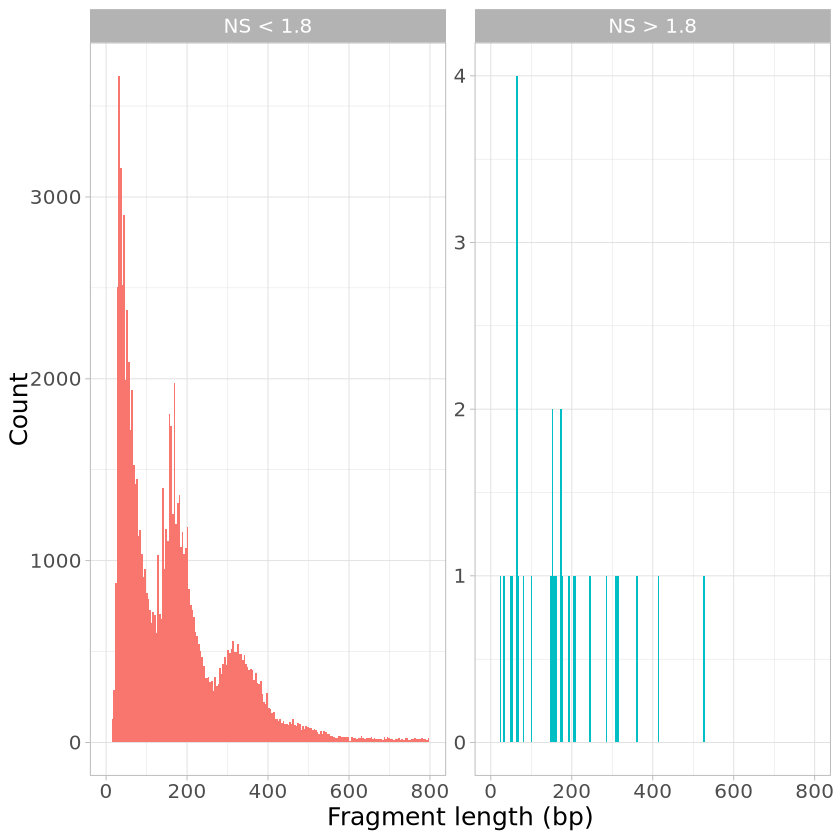

In [19]:
# 1.8 is standard threshold.
## Seocnd peak at mono-nucleosomal region, and they increment as more nucleosomes are present. Periodical pattern is good for this metric.
multi_object$nucleosome_group <- ifelse(multi_object$nucleosome_signal > 1.8, 'NS > 1.8', 'NS < 1.8')
FragmentHistogram(object = multi_object, group.by = 'nucleosome_group')+
    theme_light() + theme(text=element_text(size=15)) + NoLegend()

In [20]:
table(multi_object$nucleosome_group)


NS < 1.8 NS > 1.8 
    1838      170 

## Distribution pre-filtering

Warning message:
"Removed 865 rows containing non-finite outside the scale range
(`stat_ydensity()`)."
Warning message:
"Removed 728 rows containing missing values or values outside the scale range
(`geom_point()`)."


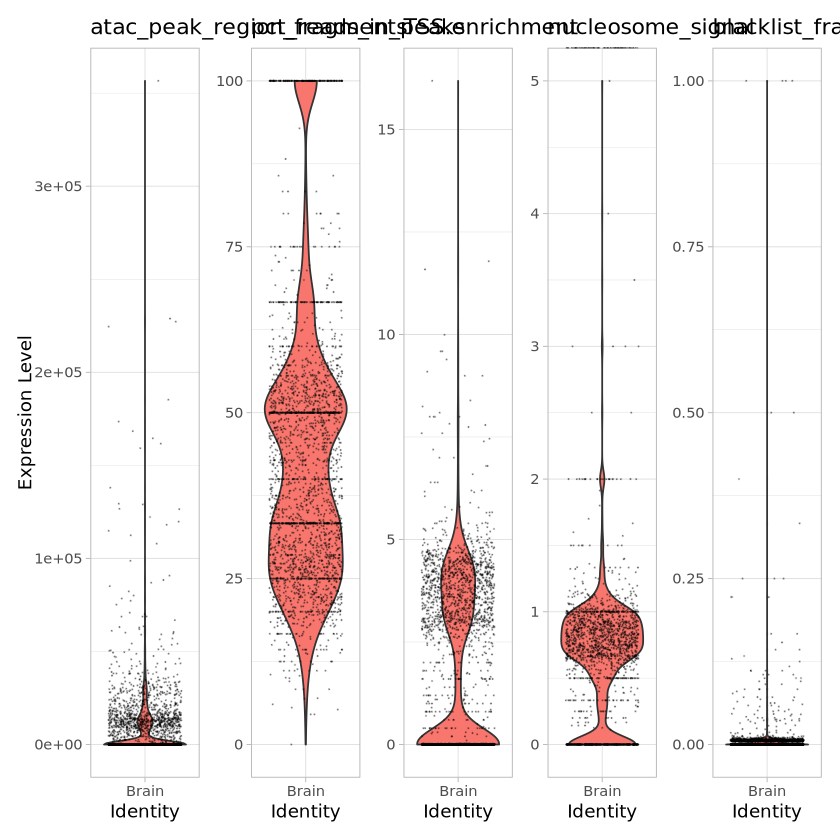

In [21]:
## Violin of QC metrics
VlnPlot(
  object = multi_object,
  features = c('atac_peak_region_fragments','pct_reads_in_peaks',
               'TSS.enrichment', 'nucleosome_signal', 'blacklist_fraction'),  
  pt.size = 0.01, alpha = 0.3, ncol=5
) & theme_light() & NoLegend() 


Warning message in scale_x_log10():
"log-10 transformation introduced infinite values."


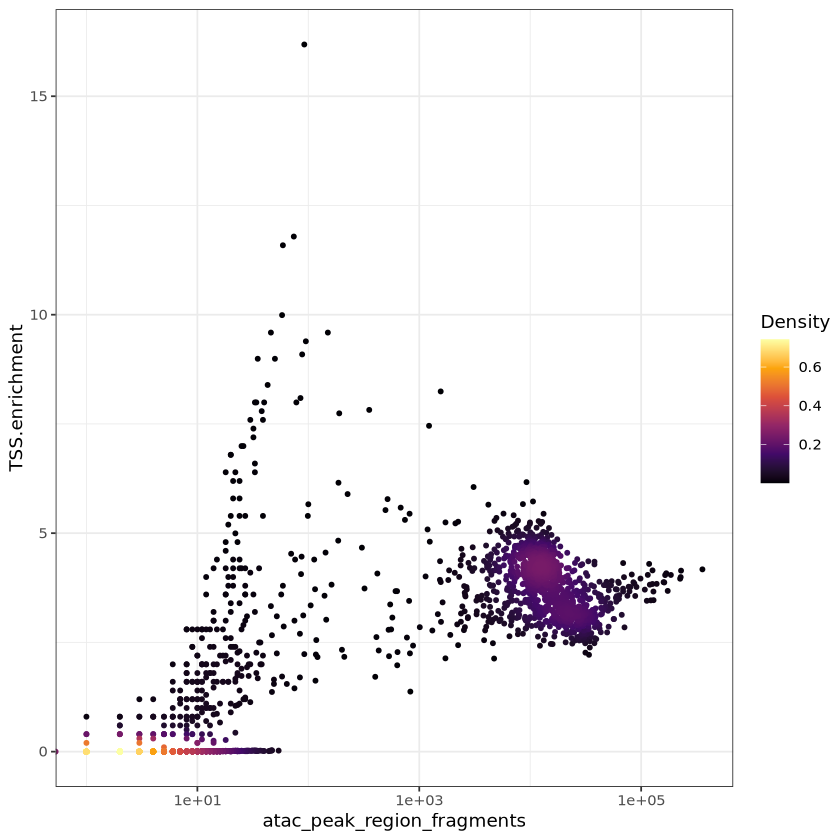

In [22]:
## Cloud in right side is good quality cells, left corner is low quality cells
DensityScatter(multi_object, x= 'atac_peak_region_fragments', y = 'TSS.enrichment', log_x = TRUE, quantiles = F)

### Correlation between ATC and RNA quality metrics

Warning message in scale_y_log10():
"log-10 transformation introduced infinite values."


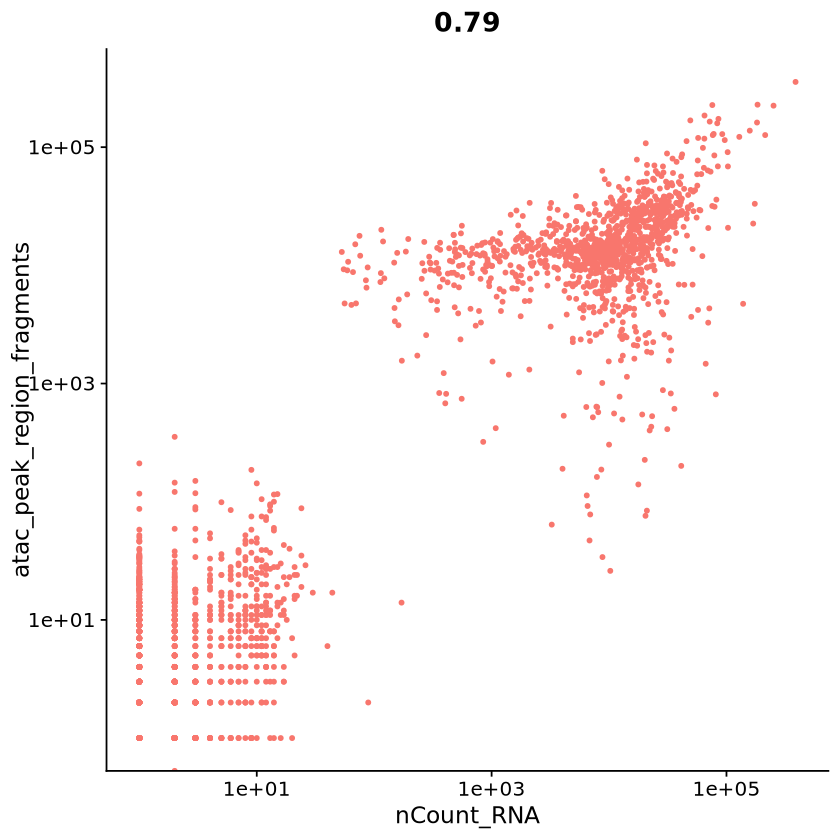

In [ ]:
# They are correlated, cells that fail for one assay also fail for the other
# Since is not perfectly simetrical, it means that there are more cells that fail for ATAC than for RNA
FeatureScatter(
  object = multi_object,
  feature1 = "nCount_RNA", 
  feature2 = "atac_peak_region_fragments",
  log=TRUE
) + NoLegend()

## Removing bad quality cells

In [24]:
## Filter out cells that are outliers for these QC metrics
mObj_filtered <- subset(
  x = multi_object,
  subset = nCount_RNA > 500 & nCount_RNA < 75000 & ## UMIs (molecules) per cell tagged, this filter is standard, and we are avoiding multiplets
    percent.mt < 5 &
    atac_peak_region_fragments > 1500 & atac_peak_region_fragments < 75000 &
    pct_reads_in_peaks > 15 &       
    blacklist_fraction < 0.025 &
    nucleosome_signal < 2 &  
    TSS.enrichment > 2 & TSS.enrichment < 8
)
mObj_filtered

An object of class Seurat 
163885 features across 1032 samples within 2 assays 
Active assay: ATAC (134029 features, 0 variable features)
 2 layers present: counts, data
 1 other assay present: RNA

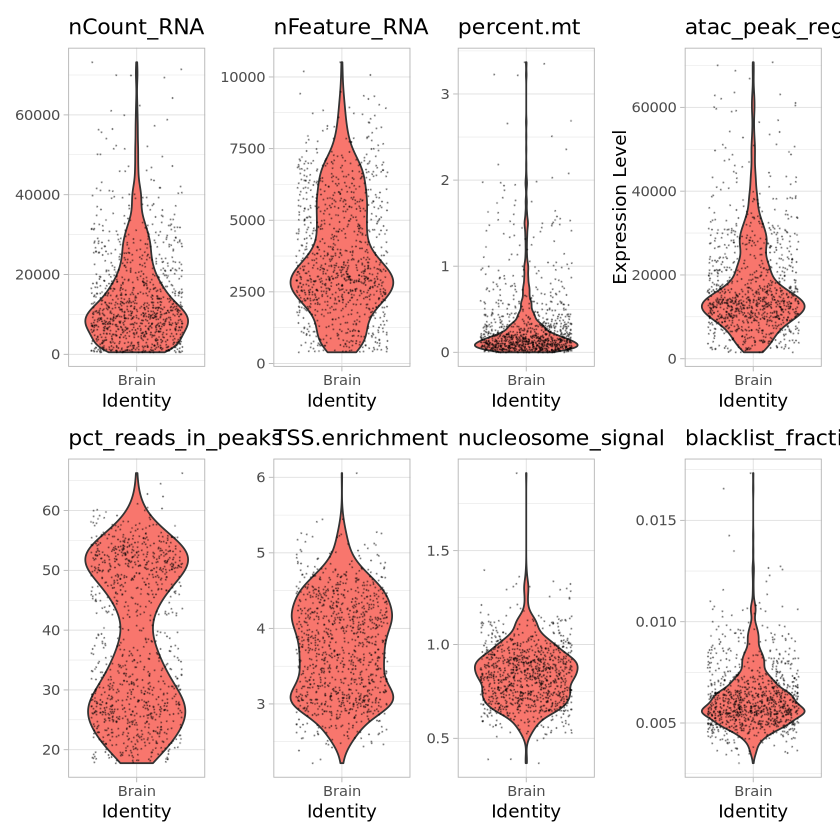

In [25]:
## Distribution post filtering
VlnPlot(
  object = mObj_filtered,
  features = c('nCount_RNA','nFeature_RNA', 'percent.mt', 'atac_peak_region_fragments',
               'pct_reads_in_peaks', 'TSS.enrichment', 'nucleosome_signal', 'blacklist_fraction'),  
  pt.size = 0.01, alpha = 0.3, ncol=4
) & theme_light() & NoLegend() 


In [26]:
## Replace main object with the filtered one
multi_object <- mObj_filtered

rm(mObj_filtered)
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,15644453,835.6,71965468,3843.4,68859413,3677.5
Vcells,129585943,988.7,531125383,4052.2,684945094,5225.8


## Normalization

### RNA-seq assay

Normalizes the feature expression measurements for each cell by the total expression, multiplies this by a scale factor (10,000 by default), and log-transforms the result. In Seurat v5, Normalized values are stored in `obj[["RNA"]]$data`

In [27]:
DefaultAssay(multi_object) <- "RNA"
# Normalize RNA assay
multi_object <- NormalizeData(multi_object, normalization.method = "LogNormalize", scale.factor = 10000)


Normalizing layer: counts



In [28]:
## Feature selection
## Computing the highly variable features
multi_object <- FindVariableFeatures(multi_object, selection.method = "vst", nfeatures = 2000)

Finding variable features for layer counts



In [29]:
## Identify the 10 most highly variable genes
top10 <- head(VariableFeatures(multi_object), 10)

In [30]:
top2000.vst <- head(VariableFeatures(multi_object), 2000)
#top2000.mvp <- head(VariableFeatures(multi_object), 2000)

When using repel, set xnudge and ynudge to 0 for optimal results

Warning message in scale_x_log10():
"log-10 transformation introduced infinite values."


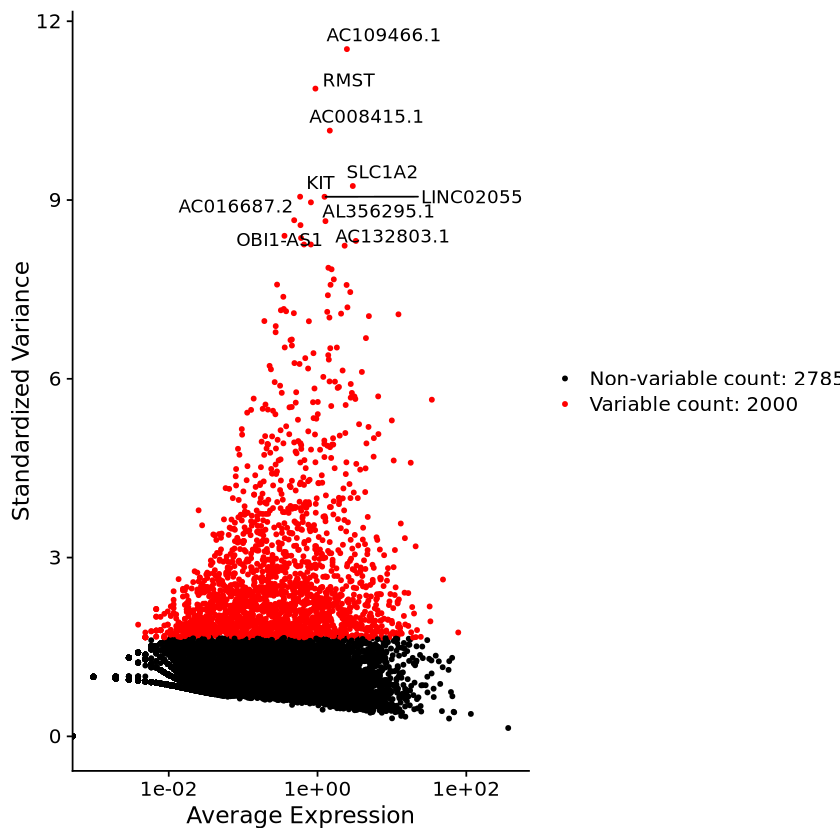

In [31]:
## Plot variable features with and without labels
plot <- VariableFeaturePlot(multi_object)
plot <- LabelPoints(plot = plot, points = top10, repel = TRUE)
plot

## Scaling

### RNA-seq assay

Next, we apply a linear transformation (‘scaling’) that is a standard pre-processing step prior to dimensional reduction techniques like PCA. The ScaleData() function:

- Shifts the expression of each gene, so that the mean expression across cells is `0`
- Scales the expression of each gene, so that the variance across cells is `1`
This step gives equal weight in downstream analyses, so that highly-expressed genes do not dominate

The results of this are stored in `multiObj[["RNA"]]$scale.data`

By default, only variable features are scaled.

You can specify the features argument to scale additional features

In [33]:
all.genes <- rownames(multi_object)
multi_object <- ScaleData(multi_object, features = all.genes)
gc()

Centering and scaling data matrix



,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,15668222,836.8,46057900,2459.8,68859413,3677.5
Vcells,166546167,1270.7,424900307,3241.8,684945094,5225.8


### ATAC-seq assay

***Normalization:*** `Signac` performs term frequency-inverse document frequency (TF-IDF) normalization. This is a two-step normalization procedure, that both normalizes across cells to correct for differences in cellular sequencing depth, and across peaks to give higher values to more rare peaks.

***Feature selection:*** The low dynamic range of scATAC-seq data makes it challenging to perform variable feature selection, as we do for scRNA-seq. Instead, we can choose to use only the top n% of features (peaks) for dimensional reduction, or remove features present in less than n cells with the `FindTopFeatures()` function. Here, we will use all features, though we note that we see very similar results when using only a subset of features (try setting min.cutoff to ‘q75’ to use the top 25% all peaks), with faster runtimes. Features used for dimensional reduction are automatically set as `VariableFeatures()` for the Seurat object by this function.

***Dimension reduction:*** We next run singular value decomposition (SVD) on the TD-IDF matrix, using the features (peaks) selected above. This returns a reduced dimension representation of the object (for users who are more familiar with scRNA-seq, you can think of this as analogous to the output of PCA).

The combined steps of TF-IDF followed by SVD are known as latent semantic indexing (LSI), and were first introduced for the analysis of scATAC-seq data by *Cusanovich et al. 2015.*

In [34]:
DefaultAssay(multi_object) <- 'ATAC'

multi_object <- RunTFIDF(multi_object) # normalizes across cells to correct cellular sequencing depth, and across peaks to give higher values to more rare peaks.

multi_object <- FindTopFeatures(multi_object, min.cutoff = 'q0') # keep all features

head(FindTopFeatures(object = multi_object[['ATAC']]['data']))

Performing TF-IDF normalization



,count,percentile
,<dbl>,<dbl>
chr1-30718015-30718946,297.5603,1.0000000
chr21-45642905-45643851,292.7021,0.9999925
chr12-6851938-6852791,292.6729,0.9999851
chr10-132537114-132538018,292.2265,0.9999776
chr3-75434980-75435829,292.1305,0.9999702
chr19-18521877-18522812,290.7417,0.9999627
